# Running inference with the MDSINE2 model and exploring the posterior

In [1]:
import mdsine2 as md2
from mdsine2.names import STRNAMES
from pathlib import Path
import matplotlib.pyplot as plt 

[DEBUG] Using default logger (stdout, stderr).


# Loading data
Here we load a small preprocessed "toy" dataset.

In [2]:
subjects_dir = Path('../data/subjects-toy')
replicates_dir = Path('../data/replicates-toy')
output_dir = Path('../output/')
fig_dir = Path('../figs/')

output_dir.mkdir(exist_ok=True, parents=True)
fig_dir.mkdir(exist_ok=True, parents=True)

# tsv_files = sorted(subjects_dir.glob('*.tsv'))
# tsv_files = {f.stem : f for f in tsv_files}

# # Read data into study object
# subjects = md2.dataset.parse(
#     name = subjects_dir.stem,
#     metadata = tsv_files['metadata'],
#     taxonomy = tsv_files['rdp_species'],
#     reads = tsv_files['counts'],
#     qpcr = tsv_files['qpcr'],
#     perturbations = tsv_files['perturbations'],
# )

tsv_files = sorted(replicates_dir.glob('*.tsv'))
tsv_files = {f.stem : f for f in tsv_files}

replicates = md2.dataset.parse(
    name = replicates_dir.stem,
    metadata = tsv_files['metadata'],
    taxonomy = tsv_files['rdp_species'],
    reads = tsv_files['counts'],
    qpcr = tsv_files['qpcr'],
    perturbations = tsv_files['perturbations'],
)

subjects = replicates


[INFO] TaxaSet parsng new taxonomy table. Resetting
[INFO] No `name` found - assuming index is the name
[DEBUG] Reseting perturbations


# Learning the Negative Binomial dispersion parameters
Before running the main inference loop we learn the negative binomial parameters from our physical replicates.
Then, we build the compute graph for learning the model that is used to learn negative binomial parameters.

In [3]:
# set negative binomial model inference parameters
params = md2.config.NegBinConfig(
    seed=0, burnin=100, n_samples=200,
    checkpoint=100, 
    basepath=str(output_dir / "negbin")
)

# Build the compute graph to learn negative binomial parameters
mcmc_negbin = md2.negbin.build_graph(
    params=params, 
    graph_name=replicates.name, 
    subjset=replicates
    )

# Run inference to learn the negative binomial parameters
mcmc_negbin = md2.negbin.run_graph(
    mcmc_negbin, 
    crash_if_error=True
)

# Print a summary of a0 and a1 posterior
print('a0', md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0]))
print('a1', md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1]))

[DEBUG] Available subjects: 2-D10,2-D8,2-D9
[DEBUG] Subject 2-D10, available qpcr: 0.0,1.0,2.0,3.0,4.0,5.0
[DEBUG] Subject 2-D8, available qpcr: 0.0,1.0,2.0,3.0,4.0,5.0
[DEBUG] Subject 2-D9, available qpcr: 0.0,1.0,2.0,3.0,4.0,5.0
[INFO] Setting Single Write, Multiple Read Mode
[INFO] Setting the trace of learned parameters
[INFO] #######################################
[INFO] Setting the trace of Negative binomial dispersion a0
[INFO] Setting the trace of Negative binomial dispersion a1
[INFO] Setting the trace of Filtering
[INFO] Setting the trace for diagnostic variables
[INFO] ##########################################
  0%|          | 1/200 [00:00<00:48,  4.12it/s][DEBUG] Inference iteration 100/200, time: 0.35576415061950684
[DEBUG] Negative binomial dispersion a0: Value: 1.9598217368212737e-10, Acceptance rate: 1.0
[DEBUG] Negative binomial dispersion a1: Value: 0.0717629171067232, Acceptance rate: 0.58
[DEBUG] Filtering: no-mp : Time: 0.0006, Acc: [0.333, 0.467, 0.333], data/se

Here we visualize the fit of the learned negative binomial model. This is not representative of the real results because we only have the 15 of the most abundant taxa here.

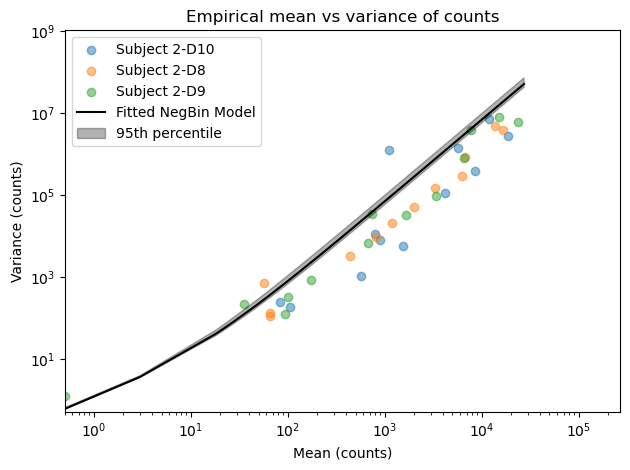

In [4]:
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc_negbin)
fig.tight_layout()
plt.show()

# Run inference on the full model
### Initialize and set model hyperparameters
Here we use the learned parameters from the negative binomial model to run inference with the full model. First, we'll create a routine that takes our mcmc object as input and plots posterior quantities.

In [5]:
def visualize(mcmc, study, seed):
    """ Viz posteriors.
    """
    growth = mcmc.graph[STRNAMES.GROWTH_VALUE]
    growth_rates_trace = growth.get_trace_from_disk(section='entire')

    growth_rates_mean = md2.summary(growth)['mean']
    print('Mean growth rates for taxa over posterior', growth_rates_mean)

    # Visualize trace for the first taxa
    md2.visualization.render_trace(growth_rates_trace[:,0], n_burnin=50, **{'title': 'OTU_1 Growth rate'})
    plt.savefig(fig_dir / 'posterior_growth_rates_{:04d}.png'.format(seed))

    # Process variance
    processvar = mcmc.graph[STRNAMES.PROCESSVAR]
    pv_rates_trace = processvar.get_trace_from_disk(section='entire')

    md2.visualization.render_trace(pv_rates_trace, n_burnin=50, **{'title': 'process variance'})
    plt.savefig(fig_dir / 'posterior_process_variance_{:04d}.png'.format(seed))

    # Taxa module assignments
    clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
    md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
    taxa = mcmc.graph.data.taxa

    # Visualize co-cluster posterior probability
    coclusters = md2.summary(mcmc.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
    md2.visualization.render_cocluster_probabilities(coclusters, taxa=study.taxa,
        yticklabels='%(paperformat)s | %(index)s')#, order=order)
    plt.savefig(fig_dir / 'posterior_cocluster_probs_{:04d}.png'.format(seed))

    # Visualize trace for number of modules
    md2.visualization.render_trace(clustering.n_clusters)
    plt.savefig(fig_dir / 'posterior_num_modules_trace_{:04d}.png'.format(seed))


Here we run inference, iterate through different seed values.

In [6]:
# Get a0 and a1 from negbin (get the mean of the posterior) and fixes them for inference
a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

seeds = [0, 1]
chains = []

for seed in seeds:
    chain_basepath = output_dir / "mdsine2" / (subjects.name + "{:04d}".format(seed))
    chain_basepath.mkdir(exist_ok=True, parents=True)

    # Initialize parameters of the model 
    params = md2.config.MDSINE2ModelConfig(
        basepath=str(chain_basepath), 
        seed=seed,
        burnin=50, 
        n_samples=100, 
        negbin_a0=a0, negbin_a1=a1, 
        checkpoint=50
    )

    # The default number of modules is 30, which is larger than the number of taxa
    # that we have in this dataset, which would throw a flag.
    params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

    # Initilize the graph
    mcmc = md2.initialize_graph(params=params, graph_name=subjects.name, subjset=subjects)

    # Perform inference
    mcmc = md2.run_graph(mcmc, crash_if_error=True)

    visualize(mcmc, subjects, seed)
    chains.append(mcmc)

[INFO] max_value found: 143666951174.38287, scaling_factor: 6.960543060360489e-10
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 6.9605E-10


KeyError: '2-D10'

In [8]:
start = 10
end = 20
vname = STRNAMES.GROWTH_VALUE

rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Growth parameter r-hat:', rhat)

vname = STRNAMES.CONCENTRATION
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Concentration parameter r-hat:', rhat)

vname = STRNAMES.PROCESSVAR
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Process variance parameter r-hat:', rhat)

Growth parameter r-hat: [1.032635   0.96650291 1.04013793 1.37479105 1.02404157 1.14941306
 1.02271872 1.69787501 1.08393635 1.04436792 0.96118165 1.11885242
 0.97246385 1.25278847 1.21613697]
Concentration parameter r-hat: [2.00446694]
Process variance parameter r-hat: [2.57704077]


[INFO] max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
[INFO] There are 686 qPCR measurements for 3 buckets. Each bucket is 228 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.
  9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5
 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.
 50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5
 60.  60.5 61.  62.  63.  64.  64.5]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Fixed topology initialization


[ERROR] 25th percentile failed
[ERROR] 75th percentile failed


[INFO] Number of clusters: 5
[INFO] Clusters assigned: [0 0 0 1 4 2 3 1 1 1 1 0 3 0 0]
[INFO] Clustering set to:
Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100490
	members: ['ASV_1', 'ASV_2', 'ASV_3', 'ASV_12', 'ASV_14', 'ASV_15']
	size: 6
Cluster 100491
	members: ['ASV_4', 'ASV_8', 'ASV_9', 'ASV_10', 'ASV_11']
	size: 5
Cluster 100492
	members: ['ASV_6']
	size: 1
Cluster 100493
	members: ['ASV_13', 'ASV_7']
	size: 2
Cluster 100494
	members: ['ASV_5']
	size: 1
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100115
	members: ['ASV_1', 'ASV_2', 'ASV_3', 'ASV_12', 'ASV_14', 'ASV_15']
	size: 6
Cluster 100116
	members: ['ASV_4', 'ASV_8', 'ASV_9', 'ASV_10', 'ASV_11']
	size: 5
Cluster 100117
	members: ['ASV_6']
	size: 1
Cluster 100118
	members: ['ASV_13', 'ASV_7']
	size: 2
Cluster 100119
	members: ['ASV_5']
	size: 1
[INFO] Initializing Process Vari

[WARNING] Automatically setting xlabels as index because there are no taxa


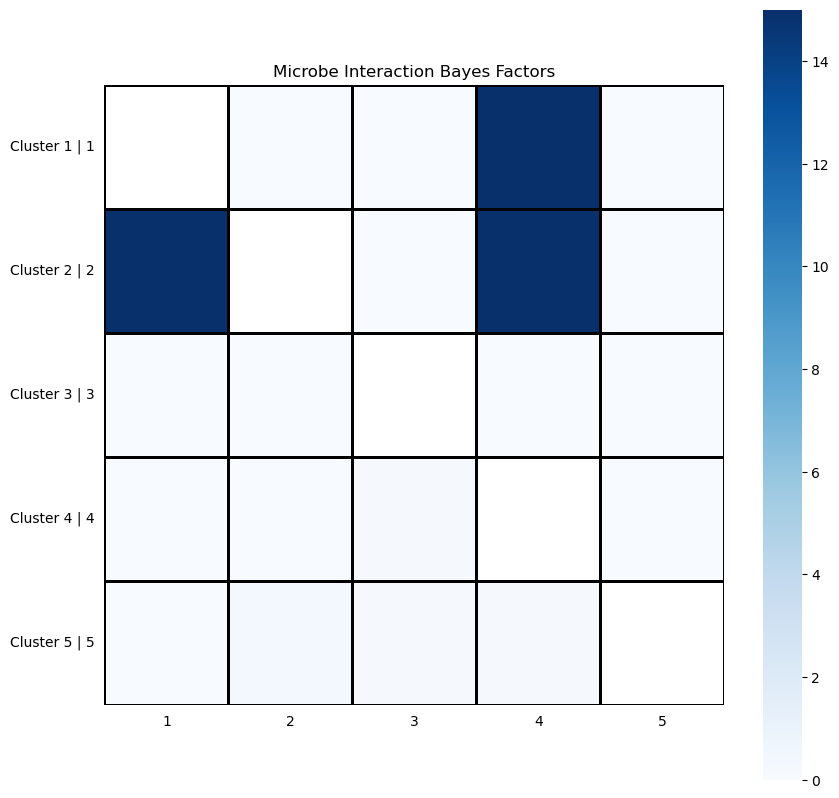

In [9]:
# Consennss clustering
basepath = output_dir / 'mdsine2-fixed-cluster'
basepath.mkdir(exist_ok=True)

# Use the clustering from a previous as the clustering assignment
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# Do not learn the clustering parameters
params.LEARN[STRNAMES.CLUSTERING] = False
params.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = str(chain_basepath / "mcmc.pkl")

mcmc = md2.initialize_graph(params=params, graph_name=subjects.name, subjset=subjects)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

[WARNING] Automatically setting xlabels as index because there are no taxa


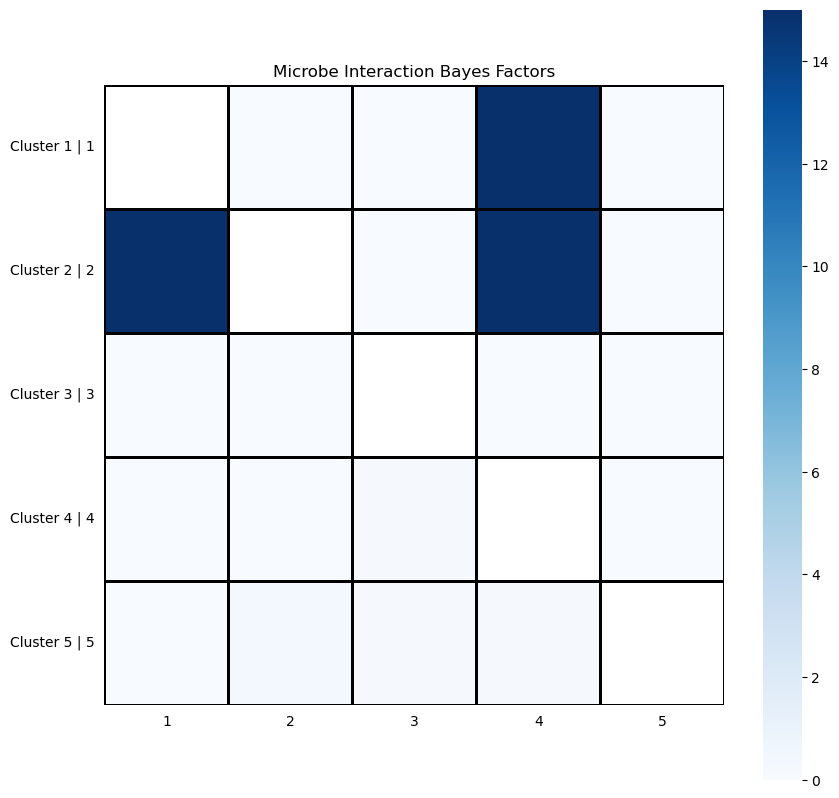

In [10]:

# Plot bayes factors for module-module interactions
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
bf_taxa = md2.generate_interation_bayes_factors_posthoc(mcmc)
bf_clustering = md2.condense_fixed_clustering_interaction_matrix(bf_taxa, clustering=clustering)

labels = ['Cluster {} | {}'.format(i+1, i+1) for i in range(len(clustering))]
md2.visualization.render_bayes_factors(bf_clustering, yticklabels=labels)
plt.savefig(fig_dir / 'posterior_fix_assignments_{:04d}.png'.format(seed))